<h1>Sieci neuronowe - ćwiczenie 6</h1>

In [ ]:
!pip install torch torchvision

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassF1Score, MulticlassRecall

In [2]:
torch.cuda.is_available() # check if torch is available to use GPU

False

In [3]:
# Def subset from whole dataset
def get_subset(data: torchvision.datasets.mnist.FashionMNIST, percent: int) -> torchvision.datasets.mnist.FashionMNIST:
    choices = np.random.choice(len(data), size=(int(len(data) * (percent / 100)),), replace=False) 
    return torch.utils.data.Subset(data, choices)

In [4]:
train_set = torchvision.datasets.FashionMNIST('path', download = True, train = True, transform = transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST('path', download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))


0.2%

100.0%


Extracting path/FashionMNIST/raw/train-images-idx3-ubyte.gz to path/FashionMNIST/raw



100.0%


Extracting path/FashionMNIST/raw/train-labels-idx1-ubyte.gz to path/FashionMNIST/raw



100.0%


Extracting path/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to path/FashionMNIST/raw



100.0%

Extracting path/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to path/FashionMNIST/raw



In [5]:
data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True)
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=True)

In [6]:
def lable_name(label: torch.Tensor):
    result = ""
    match label:
        case 0:
            result = "T-shirt/top"
        case 1:
            result = "Trouser"
        case 2:
            result = "Pullover"
        case 3:
            result = "Dress"
        case 4:
            result = "Coat"
        case 5:
            result = "Sandal"
        case 6:
            result = "Shirt"
        case 7:
            result = "Sneaker"
        case 8:
            result = "Bag"
        case 9:
            result = "Ankle boot"
    return result
            

Dress, Pullover, Trouser, Dress, Bag, T-shirt/top, Sneaker, Trouser, Ankle boot, Ankle boot, Pullover, Shirt, Trouser, Ankle boot, Shirt, Sandal, 

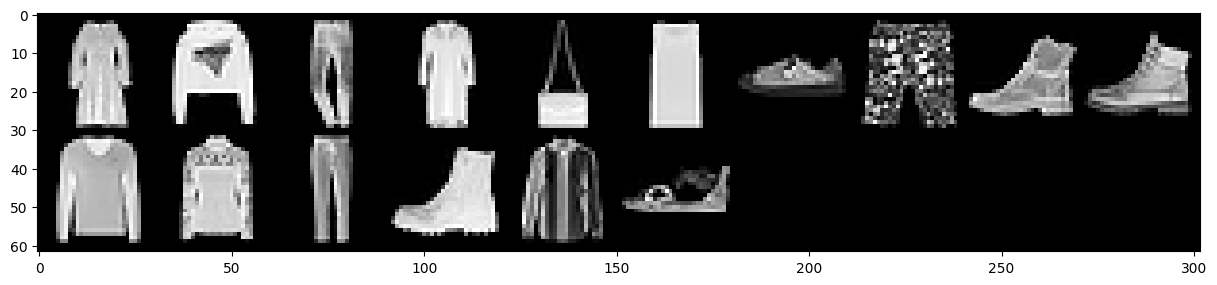

In [7]:
sample_images, sample_labels = next(iter(data_loader_train))
grid = torchvision.utils.make_grid(sample_images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

for _, label in enumerate(sample_labels):
    print(lable_name(label), end = ", ")

In [30]:
class MultilayerNetworkCNN(torch.nn.Module):
    def __init__(self, hidden_layers_sizes: tuple, input_size: int, output_size: int, out_channels: int, kernel_size: int, pool_size: int):
        super(MultilayerNetworkCNN, self).__init__()

        self._layers = torch.nn.ModuleList()
        curr_size = input_size

        # Init conv2d layer with maxpool2d
        cnn_layer = torch.nn.Conv2d(curr_size, out_channels, kernel_size=kernel_size)
        torch.nn.init.normal_(cnn_layer.weight)
        torch.nn.init.normal_(cnn_layer.bias)

        self._layers.append(cnn_layer)
        self._layers.append(torch.nn.LeakyReLU())
        self._layers.append(torch.nn.MaxPool2d(kernel_size=pool_size))
        self._layers.append(torch.nn.Flatten())

        for hidden_layer_size in hidden_layers_sizes:
            curr_size = hidden_layer_size
            layer = torch.nn.LazyLinear(curr_size)
            self._layers.append(layer)
            self._layers.append(torch.nn.LeakyReLU())
        output_layer = torch.nn.LazyLinear(output_size) 
        self._layers.append(output_layer)
        self._layers.append(torch.nn.LogSoftmax(dim=1))

    def forward(self, inputs):
        x = inputs
        for layer in self._layers:
            x = layer(x)
        return x

In [9]:
def train_model(model: torch.nn.Module, train_set: torch.Tensor, test_set: torch.Tensor, batch_size: int, optimizer, loss, max_iter: int, learning_rate: float, output_size: int, verb=False):
    
    optimizer = optimizer(model.parameters(), lr = learning_rate) 

    losses = []
    losses_test = []

    accuracy = []
    precision = []
    f_score = []
    recalls = []

    if batch_size > len(train_set):
        batch_size = len(train_set)

    data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

    metric_accuracy = MulticlassAccuracy(num_classes=output_size)
    metric_precision = MulticlassPrecision(num_classes=output_size)
    metric_f_score = MulticlassF1Score(num_classes=output_size)
    metric_recall = MulticlassRecall(num_classes=output_size)

    for index in range(max_iter): #learn for max_iter  
        curr_train_loss = 0   
        curr_test_loss = 0
        metric_accuracy.reset()
        metric_precision.reset()
        metric_f_score.reset()
        metric_recall.reset()
        
        # for each batch perform learning
        for x_train_batch, y_train_batch in data_loader_train:
            optimizer.zero_grad()
            y_pred = model(x_train_batch.view(batch_size, 1, 28, 28))
            loss_value = loss(y_pred, y_train_batch)
            loss_value.backward()
            optimizer.step()
            curr_train_loss += loss_value.item()
                
        losses.append(curr_train_loss / len(data_loader_train))

        with torch.no_grad():
            model.eval()
            for x_test_batch, y_test_batch in data_loader_test:
                test_pred = model(x_test_batch)
                loss_test_value = loss(test_pred, y_test_batch)
                curr_test_loss += loss_test_value.item()

                #calculate scores for each batch of iteration
                metric_accuracy.update(test_pred, y_test_batch)
                metric_precision.update(test_pred, y_test_batch)
                metric_f_score.update(test_pred, y_test_batch)
                metric_recall.update(test_pred, y_test_batch)

            losses_test.append(curr_test_loss / len(data_loader_test))    
            accuracy.append(metric_accuracy.compute())
            precision.append(metric_precision.compute())
            f_score.append(metric_f_score.compute())
            recalls.append(metric_recall.compute())

        if verb and index % 10 == 0:
            print("---------------------------------------------- Interation " + str(index))
            print("Train loss on " + str(index) + " iteration: ", losses[index])
            print("Test loss on " + str(index) + " iteration: ", losses_test[index])
            print("Accuracy on " + str(index) + " iteration: ", accuracy[index])
            print("Precision on " + str(index) + " iteration: ", precision[index])
            print("Recall on " + str(index) + " iteration: ", recalls[index])
            print("Fscore on " + str(index) + " iteration: ", f_score[index])
            print("----------------------------------------------\n")

    print("Result of learning process for " + str(max_iter) + " iterations")
    print("--------------------------------------------------------\n")
    print("Train loss: ", losses[-1])
    print("Test loss: ", losses_test[-1])
    print("----------------------------------------------\n")
    print("Scores")
    print("Accuracy: ", accuracy[-1])
    print("Precision: ", precision[-1])
    print("F_score: ", f_score[-1])
    print("Recall: ", recalls[-1])    
    return losses, losses_test, accuracy, f_score, recalls

In [10]:
def plot_learning(losses: list, losses_test: list, title: str, axs = None):
    if axs == None:
        plt.plot(np.arange(len(losses)), losses, label="Train Loss")
        plt.plot(np.arange(len(losses)), losses_test, label="Test loss")
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        axs.plot(np.arange(len(losses)), losses, label="Train Loss")
        axs.plot(np.arange(len(losses)), losses_test, label="Test loss")
        axs.set_title(title)
        axs.legend()

<h1>Eksperymenty</h1>

In [40]:
optimizer = torch.optim.Adam
loss = torch.nn.CrossEntropyLoss()
max_iter = 200
verbose = True
train_set_6 = get_subset(train_set, 6)
test_set_6 = get_subset(test_set, 6)
learning_rate = 0.001

#1 Liczba neuronów w warstwie ukrytej
hiddenLayer_20 = (20,)
hiddenLayer_50 = (50,)

# Dwuwarstwowa sieć
hiddenLayer_20_10 = (20, 10)
hiddenLayer_50_30 = (50, 30)

#2 Rozmiar batch'a
batch_size_1 = 16
batch_size_2 = 100
batch_size_3 = 1000

#3 Liczba przykładów uczących
train_set_1 = get_subset(train_set, 1)
test_set_1 = get_subset(test_set, 1)
train_set_10 = get_subset(train_set, 10)
test_set_10 = get_subset(test_set, 10)

#4 Zaburzenie danych
train_set_gauss = torchvision.datasets.FashionMNIST('path', download = True, train = True, transform = transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(kernel_size=(7, 7))]))
test_set_gauss = torchvision.datasets.FashionMNIST('path', download = True, train = False, transform = transforms.Compose([transforms.ToTensor(), transforms.GaussianBlur(kernel_size=(7, 7))]))

train_set_gauss_6 = get_subset(train_set_gauss, 6)
test_set_gauss_6 = get_subset(test_set_gauss, 6)


In [32]:
def init_weights_and_bias(model):
    if isinstance(model, torch.nn.Conv2d) or isinstance(model, torch.nn.Linear):
        torch.nn.init.normal_(model.weight)
        torch.nn.init.normal_(model.bias)

In [33]:
plt.style.use('seaborn-v0_8-muted')

# options [0] -> hidden_layers, [1] -> train_set, [2] -> test_set, [3] -> output_size, [4] -> batch_size
def run_models(options: list, options_title: list):
    fig, axs = plt.subplots(1, len(options), figsize=(20, 5))
    for option_index, option in enumerate(options):
        print(options_title[option_index])
        input_size = 1
        model = MultilayerNetworkCNN(option[0], input_size, option[3], 16, 3, 2)
        dummy = torch.rand(1, 1, 28, 28)
        model(dummy)
        model.apply(init_weights_and_bias)
        result = train_model(model, option[1], option[2], option[4], optimizer, loss, max_iter, learning_rate, option[3], verb=verbose)
        plot_learning(result[0], result[1], options_title[option_index], axs[option_index])


<h1>Jednowarstwowa sieć</h1>

<h2>#1 Liczba neuronów w warstwie ukrytej</h2>

Set 6% Adam lr: 0.001 hidden layer: (20,) and batch size: 16
---------------------------------------------- Interation 0
Train loss on 0 iteration:  28.8208517159356
Test loss on 0 iteration:  5.71994108589072
Accuracy on 0 iteration:  tensor(0.1893)
Precision on 0 iteration:  tensor(0.2604)
Recall on 0 iteration:  tensor(0.1893)
Fscore on 0 iteration:  tensor(0.1756)
----------------------------------------------

---------------------------------------------- Interation 10
Train loss on 10 iteration:  0.941468491686715
Test loss on 10 iteration:  1.155525023999967
Accuracy on 10 iteration:  tensor(0.6535)
Precision on 10 iteration:  tensor(0.6486)
Recall on 10 iteration:  tensor(0.6535)
Fscore on 10 iteration:  tensor(0.6463)
----------------------------------------------

---------------------------------------------- Interation 20
Train loss on 20 iteration:  0.6242634240786235
Test loss on 20 iteration:  0.8663521558046341
Accuracy on 20 iteration:  tensor(0.7455)
Precision on 20 

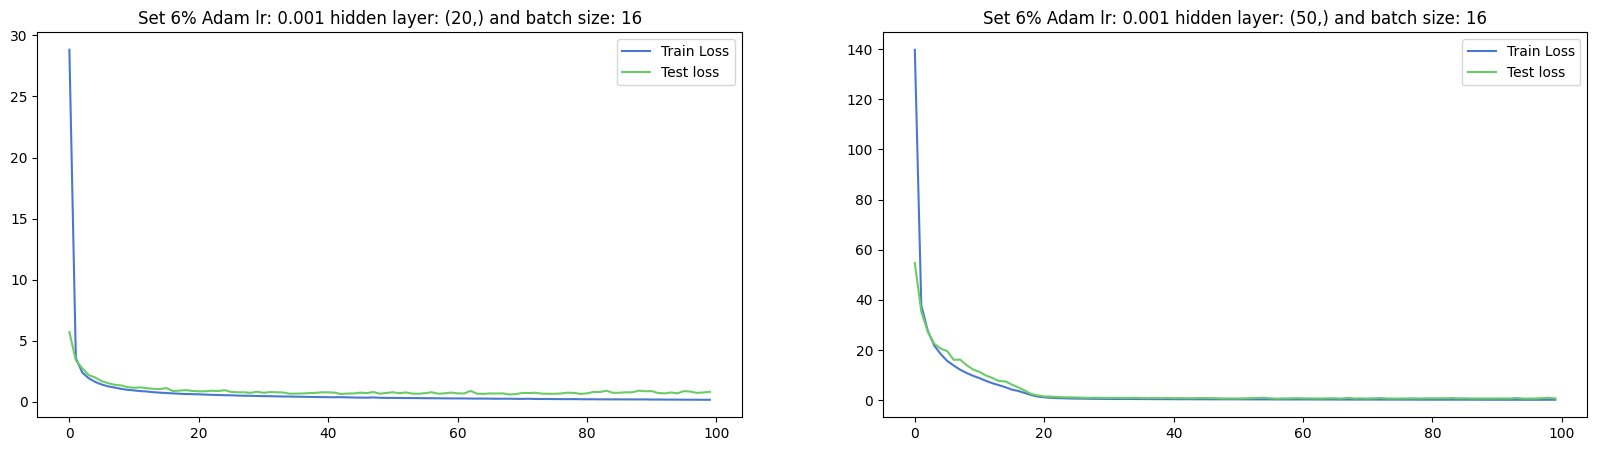

In [36]:
options_neurons_size = [[hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_50, train_set_6, test_set_6, 10, batch_size_1]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_50) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#2 Rozmiar batch'a</h2>

In [ ]:
options_neurons_size = [[hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_2],
                        [hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_3]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_2),
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_3)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#3 Liczba przykładów uczących</h2>

In [ ]:
options_neurons_size = [[hiddenLayer_20, train_set_1, test_set_1, 10, batch_size_1], 
                        [hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1],
                        [hiddenLayer_20, train_set_10, test_set_10, 10, batch_size_1]]

options_neurons_titles = ["Set 1% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1),
                          "Set 10% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1)]

run_models(options_neurons_size, options_neurons_titles)

<h2>#4 Zaburzenie danych</h2>

Set 6% Adam lr: 0.001 hidden layer: (20,) and batch size: 16
---------------------------------------------- Interation 0
Train loss on 0 iteration:  109.87335736380683
Test loss on 0 iteration:  8.025270468310305
Accuracy on 0 iteration:  tensor(0.2889)
Precision on 0 iteration:  tensor(0.3401)
Recall on 0 iteration:  tensor(0.2889)
Fscore on 0 iteration:  tensor(0.2522)
----------------------------------------------

---------------------------------------------- Interation 10
Train loss on 10 iteration:  1.0896169543266296
Test loss on 10 iteration:  1.1818465715960453
Accuracy on 10 iteration:  tensor(0.6031)
Precision on 10 iteration:  tensor(0.5913)
Recall on 10 iteration:  tensor(0.6031)
Fscore on 10 iteration:  tensor(0.5960)
----------------------------------------------

---------------------------------------------- Interation 20
Train loss on 20 iteration:  0.7339948662784365
Test loss on 20 iteration:  0.8166179123677706
Accuracy on 20 iteration:  tensor(0.7069)
Precision o

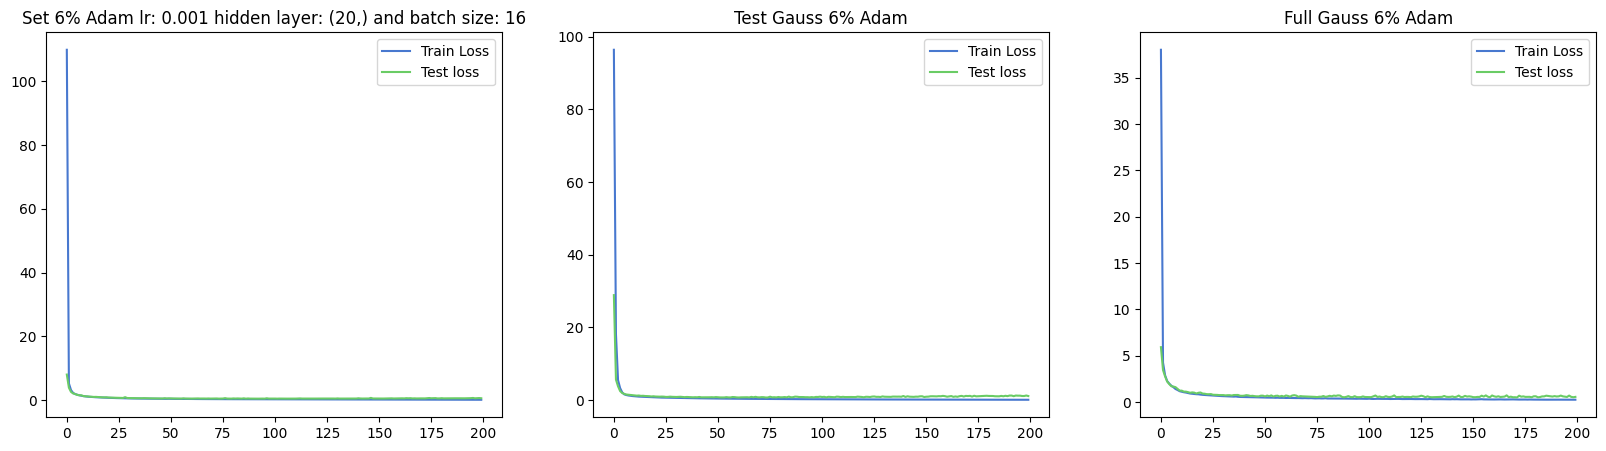

In [41]:
options_neurons_size = [[hiddenLayer_20, train_set_6, test_set_6, 10, batch_size_1], 
                        [hiddenLayer_20, train_set_6, test_set_gauss_6, 10, batch_size_1],
                        [hiddenLayer_20, train_set_gauss_6, test_set_gauss_6, 10, batch_size_1]]

options_neurons_titles = ["Set 6% Adam lr: " + str(learning_rate) + " hidden layer: " + str(hiddenLayer_20) + " and batch size: " + str(batch_size_1), 
                          "Test Gauss 6% Adam",
                          "Full Gauss 6% Adam"]

run_models(options_neurons_size, options_neurons_titles)

<p><i>Wykonane przez Szymona Sawczuka nr indeksu 260287</i></p>